<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-Data" data-toc-modified-id="Get-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get Data</a></span><ul class="toc-item"><li><span><a href="#Data-Checks" data-toc-modified-id="Data-Checks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Checks</a></span></li></ul></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clean Data</a></span><ul class="toc-item"><li><span><a href="#Clean-source-column" data-toc-modified-id="Clean-source-column-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clean source column</a></span></li><li><span><a href="#Clean-Age-Columns" data-toc-modified-id="Clean-Age-Columns-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clean Age Columns</a></span></li></ul></li><li><span><a href="#Clean-columns" data-toc-modified-id="Clean-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean columns</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-columns" data-toc-modified-id="Drop-unused-columns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Drop unused columns</a></span></li><li><span><a href="#Fix-column-types-and-names" data-toc-modified-id="Fix-column-types-and-names-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fix column types and names</a></span></li></ul></li><li><span><a href="#Add-trial_no" data-toc-modified-id="Add-trial_no-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add trial_no</a></span><ul class="toc-item"><li><span><a href="#Save-data" data-toc-modified-id="Save-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Descriptive-Stats" data-toc-modified-id="Descriptive-Stats-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Descriptive Stats</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Meta-Info" data-toc-modified-id="Meta-Info-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Meta Info</a></span></li><li><span><a href="#Sources" data-toc-modified-id="Sources-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Sources</a></span></li></ul></li><li><span><a href="#Desc-Stat-Tables" data-toc-modified-id="Desc-Stat-Tables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Desc Stat Tables</a></span></li><li><span><a href="#Desc-Stat-Plots" data-toc-modified-id="Desc-Stat-Plots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Desc Stat Plots</a></span></li></ul></li><li><span><a href="#Race-conditions/trials" data-toc-modified-id="Race-conditions/trials-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Race conditions/trials</a></span></li></ul></div>

# Get Data

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np 
import os
import ast


def query_database(client, query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df 

def fetch_experiment_data():
    print("Fetching data")
    key_path = f"../../secrets/google_creds.json"
    credentials = service_account.Credentials.from_service_account_file(key_path,
                                                                        scopes=[
                                                                            "https://www.googleapis.com/auth/cloud-platform"], )
    client = bigquery.Client(credentials=credentials, project=credentials.project_id)
    first_query = """SELECT * FROM
    `net_expr.trials` AS t
    INNER JOIN `net_expr.person` as p
    ON t.participant_id = p.participant_id
    WHERE
    p.is_test is FALSE AND
    p.participant_id != 'seed' AND
    world <= 6 AND
    t.response_date <= '2023-07-27T16:13:15'
    """
    df = query_database(client, first_query)
    return df
        

df = fetch_experiment_data()
df['init_array'] = df['init_array'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['exclude_from_analysis'] = 0

Fetching data


# Filter data

## Filter out er_ids

In [2]:
er_ids = ['dbe96241-4d64-4ae6-bb6d-15e5e45b0760', 'e6fdd18f-de53-4159-965a-656aa75ba88d']
df.loc[df['response_id'].isin(er_ids), 'exclude_from_analysis'] = 1
print(f"Flagging {len(er_ids)} responses shown in error".format(er_ids))

Flagging 2 responses shown in error


## Filter out false positive profanity

In [3]:
df2 = df.copy()
profane_df2 = df2[df2['is_profane'] == True]
for index, x in profane_df2.iterrows():
    pass
    #print(x['response_id'], x['response_text'])
fp = ['2e834786-dbbb-422e-975c-bb35d4418fa4', 
      '23b9ec2f-4a71-46cc-bd49-ec7de18ed184', 
      'c376d9e1-3d51-486a-a914-4e5c8a2a6453',
      '9ea1c436-1d8a-4b8f-b7b4-74729c3997d6',
      '7489e80a-65b9-4d14-b260-67908c35b4b4',
      'cf5c2549-6c72-4532-8355-9de800655df6',
      'a44e3014-b960-409a-85d5-b91e195bc6da',
      '4582d0a8-d5e1-4eed-bc40-5552eaf1a790',
      'c961cc7c-6d6e-44fd-86fc-93bc9f213854',
      'd6756b75-e0ed-4f56-bead-ab9df2ab5c12']
tp = [x for x in profane_df2['response_id'] if x not in fp]
assert len(tp) + len(fp) == len(profane_df2), "TP + FP don't add up"
print(f"There were {len(profane_df2)} ideas labled as profane. {len(fp)} were false positives. We will not analyze the true positives (n={len(tp)}), resulting in {len(df) -( df['exclude_from_analysis'].sum() + len(tp))} responses.")

# Now change profane field for the false positives in a new column called is_profane2
df['is_profane_clean'] = df['is_profane']  
df.loc[df['response_id'].isin(fp), 'is_profane_clean'] = False
df.loc[df['response_id'].isin(tp), 'exclude_from_analysis'] = 1
assert np.sum(df['is_profane_clean']) == len(tp), "Mismatch: {Profane2} not equal to {profane} - {fp}"

There were 46 ideas labled as profane. 10 were false positives. We will not analyze the true positives (n=36), resulting in 3414 responses.


## But before proceeding, let's make sure no correlation between conditions and profanity.

In [4]:
from scipy.stats import chi2_contingency

def chi_square_test(dv, iv, df):
    response_sum = np.sum(1*df[dv])
    response_mean = np.round(np.mean(1*df[dv])*100,2)
    cross_tab = pd.crosstab(df[dv], df[iv])
    chi2_test = chi2_contingency(cross_tab)
    chi2_stat = chi2_test[0]
    p_value = chi2_test[1]
    dof = chi2_test[2]
    # Format the string for LaTeX with the chi-square symbol
    latex_string = "{} (n={}; {}\% of sample) did not differ by {} ($\chi^2$({}) = {:.2f}, p = {:.2f})".format(dv.replace("_", ""), response_sum, response_mean, iv.replace("_", ""),dof, chi2_stat, p_value)
    print(latex_string)
    return latex_string
# Testing the function

df['item_condition'] = df['item'] + df['condition']

for dv in ['is_profane', 'is_profane_clean', 'exclude_from_analysis']:
    for iv in ['item', 'condition', 'item_condition']:
        print(f"{dv} by {iv}")
        chi_square_test(dv, iv, df)
        print()

is_profane by item
isprofane (n=46; 1.33\% of sample) did not differ by item ($\chi^2$(4) = 3.66, p = 0.45)

is_profane by condition
isprofane (n=46; 1.33\% of sample) did not differ by condition ($\chi^2$(4) = 6.06, p = 0.19)

is_profane by item_condition
isprofane (n=46; 1.33\% of sample) did not differ by itemcondition ($\chi^2$(24) = 26.85, p = 0.31)

is_profane_clean by item
isprofaneclean (n=36; 1.04\% of sample) did not differ by item ($\chi^2$(4) = 4.51, p = 0.34)

is_profane_clean by condition
isprofaneclean (n=36; 1.04\% of sample) did not differ by condition ($\chi^2$(4) = 2.92, p = 0.57)

is_profane_clean by item_condition
isprofaneclean (n=36; 1.04\% of sample) did not differ by itemcondition ($\chi^2$(24) = 30.21, p = 0.18)

exclude_from_analysis by item
excludefromanalysis (n=38; 1.1\% of sample) did not differ by item ($\chi^2$(4) = 5.10, p = 0.28)

exclude_from_analysis by condition
excludefromanalysis (n=38; 1.1\% of sample) did not differ by condition ($\chi^2$(4) = 

# Ideas 

## Add new column that removes excluded ideas

In [5]:
import re
excluded = set(df.query("exclude_from_analysis==1")['response_id'].tolist())

def remove_excluded(rids):
    rids = [x for x in rids if x not in excluded]
    return rids

df['init_array'] = df['init_array'].apply(lambda ids: [re.sub(r'_world\d+$', '', id) for id in ids])
df['init_array_minus_excluded'] = df['init_array'].apply(lambda x: remove_excluded(x))
df['ranked_array_minus_excluded'] = df['ranked_array'].apply(lambda x: remove_excluded(x))

## Add 6 new columns that have the text of each example id

For each row we add columns like:
- idea1_txt: Text of 1st idea in init_array
- (...)
- idea6_text: Text of 6th idea in init_array

I create another set of columns if somebody wants the data in a convienent format where the excluded ideas are ALSO excluded from the example set
- idea_minus_excluded1_txt: Text of 1st idea in init_array if not `exclude_from_analysis==1` else np.NaN
- (...)
- idea_minus_excluded6_txt: Text of 6th idea in init_array if not `exclude_from_analysis==1` else np.NaN

In [6]:
excluded_txt = df.query("exclude_from_analysis==1")['response_text'].tolist()
ai_seeds_df = pd.read_csv("../../data/ai_responses.csv")
human_seeds_df = pd.read_csv("../../data/seed_human_responses.csv")

def get_response_text(response_id):
    if response_id.startswith('ai_seed'):
        return ai_seeds_df.loc[ai_seeds_df['response_id'] == response_id, 'response'].values[0]
    elif response_id.startswith('human_seed'):
        return human_seeds_df.loc[human_seeds_df['response_id'] == response_id, 'response'].values[0]
    else:
        return df.loc[df['response_id'] == response_id, 'response_text'].values[0]

for i in range(1, 7):
    df['idea{}_txt'.format(i)] = ''
    df['idea_minus_excluded{}_txt'.format(i)] = ''

# Populate the new columns with the response texts
for index, row in df.iterrows():
    for i in range(min(6, len(row['init_array']))):
        matched_text = get_response_text(row['init_array'][i])
        df.loc[index, 'idea{}_txt'.format(i+1)] = matched_text
        df.loc[index, 'idea_minus_excluded{}_txt'.format(i+1)] = matched_text if matched_text not in excluded_txt else np.NaN
        
print(len(df.query("exclude_from_analysis==0")))
    

3414


## Data Checks

In [7]:
def verify_rid_unique():
    print("TEST: Does every response id occur only once?")
    unique_rds = len(df['response_id'].unique())
    all_rids = len(df['response_id'].tolist())
    if all_rids == unique_rds:
        print("YES: Every response id only occurs once")
    else:
        print("NO: Some response ids occur twice")
    
    
def verify_no_response_blank():
    print("TEST: Is it the case that all response texts have some words")
    blanks = len([x for x in df['response_id'].tolist() if x is None])
    if blanks == 0:
        print("YES: All responses have some words")
    else:
        print("NO: Some responses don't have words")
    
        
verify_rid_unique()
print()
verify_no_response_blank()

TEST: Does every response id occur only once?
YES: Every response id only occurs once

TEST: Is it the case that all response texts have some words
YES: All responses have some words


# Clean Data

## Clean source column

We tracked where traffic came from by appending different things to the request arguments for the experiment site. E.g: If posting the experiment on Facebook we would make the URL `experiment.com?from=facebook` so then `request_args` would be equal to `from=facebook`. But in some cases, no `request args` are available. This happens if somehow the request_args are stripped. There should be very few cases of this. 

In [8]:
def verify_other_source():
    print("TEST: Does every source marked as OTHER have no request args?")
    other_request_args = df.query("source=='other'")['request_args'].tolist()
    len_other = len(other_request_args)
    len_other_no_args = len([x for x in other_request_args if x == 'None'])
    if len_other == len_other_no_args:
        print("YES: For every source marked as `other`, we marked it as `other` because it does not have request args")
    else:
        print("NO: We missed categorizing some sources")
    
    

def categorize_request_args(request_args):
    request_args = request_args.lower()
    if 'facebook' in request_args:
        return 'facebook'
    elif 'chatgpt' in request_args:
        return 'r/chatgpt'
    elif 'sample' in request_args:
        return 'r/samplesize'
    elif 'writing' in request_args:
        return 'r/writing'
    elif 'internet' in request_args:
        return 'r/InternetIsBeautiful'
    elif 'creative' in request_args:
        return 'Creative Mornings newsletter'
    elif 'poetry' in request_args:
        return 'r/poetry'
    elif 'results' in request_args or 'share' in request_args:
        return 'share'
    elif "ai" in request_args:
        return "r/artificial"
    elif "singular" in request_args:
        return "r/singularity"
    else:
        return 'other'

df['source'] = df['request_args'].apply(categorize_request_args)
verify_other_source()

df['source'].value_counts()

TEST: Does every source marked as OTHER have no request args?
YES: For every source marked as `other`, we marked it as `other` because it does not have request args


Creative Mornings newsletter    1472
r/InternetIsBeautiful           1131
r/samplesize                     394
share                            260
r/chatgpt                         79
r/writing                         30
r/artificial                      24
other                             23
r/singularity                     17
r/poetry                          15
facebook                           7
Name: source, dtype: int64

## Clean Age Columns
Participants entered their age, which was an int that had to be over 18. But let's make sure nobody entered anything weird -- and by weird we will look at responses over 70 years old. From inspecting the data, it appears that responses above 74 are troll responses -- relabel as NA and report in paper. 

In [9]:
dfp = df.drop_duplicates(subset=['participant_id'])
dfp['age'].describe()

count    680.000000
mean      36.867647
std       28.688775
min       18.000000
25%       27.000000
50%       34.000000
75%       40.000000
max      444.000000
Name: age, dtype: float64

In [10]:
over_seven = dfp[dfp['age']>=70]
over_seven

,response_id,participant_id,response_text,response_date,condition,condition_order,item,world,init_array,ranked_array,...,idea_minus_excluded2_txt,idea3_txt,idea_minus_excluded3_txt,idea4_txt,idea_minus_excluded4_txt,idea5_txt,idea_minus_excluded5_txt,idea6_txt,idea_minus_excluded6_txt,source
370,2e5141b6-814c-4e5f-89f6-9fe6155915e3,7f067979-5f4b-4729-a61f-827d82f929ff,Building a straw ball house,2023-07-14 03:00:50,f_u,0,tire,3,"[723fd22b-6121-4935-82a1-54dfcecec5d9, e7726b1...","[a01068a1-ea4a-4c84-b9df-082ed1fe1b54, fd61a41...",...,Stack/arrange several into an obstacle/agility...,planter for small gardens,planter for small gardens,recycle into a dress,recycle into a dress,tire swing for backyard fun,tire swing for backyard fun,Hill racer,Hill racer,Creative Mornings newsletter
1944,5c366ee2-b272-454b-8f5f-b4b6e54e67b1,b2269ab4-bc4b-4049-b234-e240644e2cf7,to make into a bicycle tire made out of shoes,2023-07-08 17:26:18,h,0,shoe,3,"[human_seed39, human_seed37, human_seed38, hum...","[human_seed38_world3, human_seed40_world3, hum...",...,to throw it somewhere,soup bowl,soup bowl,fashion,fashion,scare someone,scare someone,measuring scoop,measuring scoop,share
1950,dbe96241-4d64-4ae6-bb6d-15e5e45b0760,d54560e4-1d65-4e08-8332-8d4eb0d9ea23,Test,2023-07-08 16:53:58,h,0,shoe,2,"[5915d456-2993-48be-b7bd-d26cad06d213, human_s...","[human_seed41_world2, human_seed40_world2, 591...",...,measuring scoop,fashion,fashion,leave tracks to follow,leave tracks to follow,Kitten transporter,Kitten transporter,Use as ganja smoking device,Use as ganja smoking device,share
2098,d2d498ec-58a0-4286-bb03-e4aa50f0486a,4c7db1ec-9ae0-4b58-b4d3-8186d5599d90,Portable cell-phone,2023-07-08 15:21:19,f_l,0,shoe,1,"[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...","[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...",...,A mallet,diy door stopper alternative,diy door stopper alternative,golf club cover,golf club cover,Nunchuck,Nunchuck,phone holder on the go,phone holder on the go,r/InternetIsBeautiful
2256,4735ccd1-f9b8-4d39-a115-5ea58265e0a2,8459a1e8-f7a7-46b1-82a2-0d99056ac3f4,store krabby patty secret formula,2023-07-08 15:49:57,f_l,0,bottle,1,"[d2a4126d-b581-4cb9-ba80-60dfc39d227b, 36b21de...","[d6829192-dce2-4a9d-9d46-e836acd74201, 36b21de...",...,"draino bomb with aluminum foil, draino, and se...","Cut off top, insert funnel into body with bait...","Cut off top, insert funnel into body with bait...",make decorative string lights,make decorative string lights,bottle vase for flowers,bottle vase for flowers,Use to purify water,Use to purify water,r/InternetIsBeautiful
3024,cde0fcff-bf2b-45b7-bcd5-a32386664c8f,ae94364d-2fb8-47d0-b909-1c9e0d97aeff,Cut legs off to use as shorts,2023-07-08 15:05:43,m_l,0,pants,0,"[ai_seed562, f28fb317-4ea6-418f-9040-dd180452c...","[ai_seed304, f28fb317-4ea6-418f-9040-dd180452c...",...,Cut it in half and use it as a long and thin b...,pant pockets pillow - stuff pant pockets with ...,pant pockets pillow - stuff pant pockets with ...,leg warmers for pets,leg warmers for pets,material for patchwork quilt,material for patchwork quilt,stitch end together and use it as a bag,stitch end together and use it as a bag,r/InternetIsBeautiful


In [11]:
print(dfp[dfp['age']>74][['participant_id', 'age']].to_latex(caption="Users whose age we replaced with missing"))

\begin{table}
\centering
\caption{Users whose age we replaced with missing}
\begin{tabular}{llr}
\toprule
{} &                        participant\_id &  age \\
\midrule
1944 &  b2269ab4-bc4b-4049-b234-e240644e2cf7 &  420 \\
1950 &  d54560e4-1d65-4e08-8332-8d4eb0d9ea23 &   90 \\
2098 &  4c7db1ec-9ae0-4b58-b4d3-8186d5599d90 &  432 \\
2256 &  8459a1e8-f7a7-46b1-82a2-0d99056ac3f4 &  444 \\
3024 &  ae94364d-2fb8-47d0-b909-1c9e0d97aeff &  111 \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
def fix_age(x):
    if pd.isnull(x):  # Check for NaN values
        return x
    elif x <= 74:
        return int(x)
    else:
        return np.NaN

df['age'] = df['age'].apply(lambda x: fix_age(x))
df['age'] = df['age'].astype('Int64')
df['age'].describe()

count    2767.000000
mean       35.094326
std        10.767012
min        18.000000
25%        27.000000
50%        34.000000
75%        40.000000
max        74.000000
Name: age, dtype: float64

# Clean columns

## Drop unused columns

Note `is_troll` was not used; the relevant column is `is_profane`. 

In [13]:
df.columns

Index(['response_id', 'participant_id', 'response_text', 'response_date',
       'condition', 'condition_order', 'item', 'world', 'init_array',
       'ranked_array', 'is_test', 'duration', 'is_troll', 'is_profane',
       'is_prolific', 'participant_id_1', 'creativity_human', 'creativity_ai',
       'dt', 'ai_feeling', 'country', 'age', 'is_test_1', 'referer',
       'request_args', 'is_prolific_1', 'prolific_id', 'gender',
       'gender_describe', 'exclude_from_analysis', 'is_profane_clean',
       'item_condition', 'init_array_minus_excluded',
       'ranked_array_minus_excluded', 'idea1_txt', 'idea_minus_excluded1_txt',
       'idea2_txt', 'idea_minus_excluded2_txt', 'idea3_txt',
       'idea_minus_excluded3_txt', 'idea4_txt', 'idea_minus_excluded4_txt',
       'idea5_txt', 'idea_minus_excluded5_txt', 'idea6_txt',
       'idea_minus_excluded6_txt', 'source'],
      dtype='object')

In [14]:
to_drop = ["is_prolific", "is_prolific_1", "prolific_id", "is_test_1", "is_troll", "dt", 'participant_id_1']
for x in to_drop:
    try:
        df = df.drop(columns = [x], axis=0)
    except KeyError:
        pass

## Fix column types and names

In [15]:
df['creativity_human'] = df['creativity_human'].astype('Int64')
df['creativity_ai'] = pd.to_numeric(df['creativity_ai'], errors='coerce').astype('Int64')
df = df.rename(columns={'world': 'response_chain'})

# Add trial_no

In [16]:
df['response_date'] = pd.to_datetime(df['response_date'])  # ensure response_date is datetime

# Trial no
df['trial_no'] = df.groupby(['response_chain', 'condition', 'item'])['response_date'].rank(method='first').astype(int)
df['trial_no_excluded'] = df[df['exclude_from_analysis'] != 1].groupby(['response_chain', 'condition', 'item'])['response_date'].rank(method='first').astype(float)

## Save data

In [17]:
df.to_csv("../../data/experiment_data/data_clean.csv")

# Descriptive Stats

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()

### Meta Info

In [19]:
df = pd.read_csv("../../data/experiment_data/data_clean.csv").query("exclude_from_analysis==0")
dfp = df.drop_duplicates(subset=['participant_id'])
dfp = pd.concat([dfp, pd.get_dummies(dfp['ai_feeling'])], axis=1)

df_new = pd.DataFrame(index=["Value"])
df_new['Unique Countries'] = [int(len(df['country'].unique()))]
df_new['Total Responses'] = [int(len(df))]
df_new['Unique Participants'] = [df['participant_id'].nunique()]
df_new['Avg Responses/Participant'] = df_new['Total Responses'] / df_new['Unique Participants']
df_new['Avg Duration/Response'] = [df['duration'].mean()]

df_new['Avg Responses/Participant'] = df_new['Avg Responses/Participant'].round(2)
df_new['Avg Duration/Response'] = df_new['Avg Duration/Response'].round(2)

latex_table = df_new.T.to_latex(index=True, caption="Summary Statistics of Experiment", label="overall_stats")
print(latex_table)


\begin{table}
\centering
\caption{Summary Statistics of Experiment}
\label{overall_stats}
\begin{tabular}{lr}
\toprule
{} &    Value \\
\midrule
Unique Countries          &    48.00 \\
Total Responses           &  3414.00 \\
Unique Participants       &   844.00 \\
Avg Responses/Participant &     4.05 \\
Avg Duration/Response     &   144.31 \\
\bottomrule
\end{tabular}
\end{table}



### Sources

In [20]:
participants = df.groupby('source')['participant_id'].nunique()
percentage_participants = (participants / df['participant_id'].nunique()) * 100
trials = df['source'].value_counts()
percentage_trials = (trials / df.shape[0]) * 100
result = pd.DataFrame({
    'Participants': participants,
    'Percentage of Participants': percentage_participants,
    'Trials': trials,
    'Percentage of Trials': percentage_trials,
})

result = result.sort_values('Participants', ascending=False)
result['Participants (N, % of total)'] = result['Participants'].astype(str) + ' (' + result['Percentage of Participants'].round(1).astype(str) + '%)'
result['Trials (N, % of total)'] = result['Trials'].astype(str) + ' (' + result['Percentage of Trials'].round(1).astype(str) + '%)'
result = result.drop(columns=['Participants', 'Percentage of Participants', 'Trials', 'Percentage of Trials'])
latex_table = result.to_latex(caption="Sources of participants and trials", label="sources")

print(latex_table)


\begin{table}
\centering
\caption{Sources of participants and trials}
\label{sources}
\begin{tabular}{lll}
\toprule
{} & Participants (N, \% of total) & Trials (N, \% of total) \\
\midrule
Creative Mornings newsletter &                  343 (40.6\%) &           1470 (43.1\%) \\
r/InternetIsBeautiful        &                  298 (35.3\%) &           1115 (32.7\%) \\
r/samplesize                 &                   94 (11.1\%) &            389 (11.4\%) \\
share                        &                    61 (7.2\%) &             250 (7.3\%) \\
r/chatgpt                    &                    19 (2.3\%) &              79 (2.3\%) \\
r/writing                    &                     7 (0.8\%) &              30 (0.9\%) \\
other                        &                     6 (0.7\%) &              22 (0.6\%) \\
r/singularity                &                     6 (0.7\%) &              13 (0.4\%) \\
r/artificial                 &                     5 (0.6\%) &              24 (0.7\%) \\
r

## Desc Stat Tables

In [21]:
import numpy as np
import pandas as pd

class DescriptiveStats:
    """
    A class for automating clean latex tables and descriptions from dataframes. 
    
    SAMPLE USAGE:
    
    dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
    dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats")
    dp.print_latex_table_categorical('gender', decimal_places=0)
    dp.print_latex_table_categorical('ai_feeling', decimal_places=0)
    
    """
    def __init__(self, df):
        self.df = df

    def print_latex_table_categorical(self, column, caption=None, label=None, decimal_places=2):
        value_counts = self.df[column].value_counts(dropna=False)
        value_counts_percentages = self.df[column].value_counts(normalize=True, dropna=False) * 100
        df_output = pd.DataFrame({column: value_counts.index, 
                                  'Counts (% of total)': [f"{count} ({percentage:.{decimal_places}f}%)" for count, percentage in zip(value_counts.values, value_counts_percentages.values)]})
        df_output[column] = df_output[column].fillna("Missing")
        df_output.set_index(column, inplace=True)
        latex_table = df_output.to_latex(index=True, caption=caption or f"Distribution of {column.replace('_', ' ').title()}", label=label or f"dist_{column}")
        print(self.generate_categorical_string(column, decimal_places))
        print(latex_table)
        
    def print_latex_table_continuous(self, columns, caption=None, label=None, decimal_places=2):
        if not isinstance(columns, list):
            columns = [columns]
        stats_list = []
        for column in columns:
            mean_value = round(self.df[column].mean(), decimal_places)
            median_value = round(self.df[column].median(), decimal_places)
            std_dev = round(self.df[column].std(), decimal_places)
            quartile_25 = round(np.percentile(self.df[column].dropna(), 25), decimal_places)
            quartile_75 = round(np.percentile(self.df[column].dropna(), 75), decimal_places)
            stats_series = pd.Series({'Mean': mean_value,
                                      'SD': std_dev,
                                      '25th Percentile': quartile_25,
                                      'Median': median_value,
                                      '75th Percentile': quartile_75},
                                     name=column)
            stats_list.append(stats_series)

        df_output = pd.concat(stats_list, axis=1)
        latex_table = df_output.T.to_latex(index=True, caption=caption or "Distribution of Continuous Variables", label=label)
        for column in columns:
            print(self.generate_continuous_string(column, decimal_places))
        print(latex_table)
        
    def generate_categorical_string(self, column, decimal_places):
        percentages = self.df[column].value_counts(normalize=True, dropna=True) * 100
        percentage_nan = self.df[column].isna().mean() * 100
        percentage_string = ", ".join([f"{percentage:.{decimal_places}f}\% {index}" for index, percentage in percentages.items()])
        percentage_string += f". {percentage_nan:.{decimal_places}f}% of responses were missing."
        return f"Of the non-missing values, the sample was {percentage_string}"

    
    def generate_continuous_string(self, column, decimal_places):
        mean_value = round(self.df[column].mean(), decimal_places)
        std_dev = round(self.df[column].std(), decimal_places)
        stats_string = f"The mean {column} was {mean_value:.{decimal_places}f} (SD = {std_dev:.{decimal_places}f})."
        return stats_string

        
dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats", label="desc_stats")
dp.print_latex_table_categorical('gender', decimal_places=0)
dp.print_latex_table_categorical('ai_feeling', decimal_places=0)

The mean age was 34.92 (SD = 10.86).
The mean creativity_ai was 57.86 (SD = 26.66).
The mean creativity_human was 58.67 (SD = 23.65).
\begin{table}
\centering
\caption{Descriptive Stats}
\label{desc_stats}
\begin{tabular}{lrrrrr}
\toprule
{} &   Mean &     SD &  25th Percentile &  Median &  75th Percentile \\
\midrule
age              &  34.92 &  10.86 &             27.0 &    33.0 &             40.0 \\
creativity\_ai    &  57.86 &  26.66 &             40.0 &    60.0 &             76.0 \\
creativity\_human &  58.67 &  23.65 &             44.0 &    62.0 &             75.0 \\
\bottomrule
\end{tabular}
\end{table}

Of the non-missing values, the sample was 50\% woman, 43\% man, 4\% non-binary, 3\% prefer_not_disclose, 1\% prefer_self_describe. 26% of responses were missing.
\begin{table}
\centering
\caption{Distribution of Gender}
\label{dist_gender}
\begin{tabular}{ll}
\toprule
{} & Counts (\% of total) \\
gender               &                     \\
\midrule
woman                &      

## Desc Stat Plots

,Unnamed: 0,condition_order,response_chain,is_test,duration,is_profane,creativity_human,creativity_ai,age,exclude_from_analysis,is_profane_clean,trial_no,trial_no_excluded,concerned,excited,neutral,gap
Unnamed: 0,1.000000,-0.149291,-0.803470,NaN,-0.020716,0.013273,-0.121162,-0.081882,-0.335867,NaN,NaN,-0.041281,-0.056798,-0.112249,0.099530,-0.025563,0.026534
condition_order,-0.149291,1.000000,0.062829,NaN,-0.113489,0.006209,-0.031771,-0.012289,0.030070,NaN,NaN,-0.016447,-0.017506,0.011071,-0.036490,0.040777,0.019757
response_chain,-0.803470,0.062829,1.000000,NaN,0.050721,-0.018202,0.107096,0.076977,0.307953,NaN,NaN,-0.008264,0.008963,0.073485,-0.073134,0.041289,-0.017828
is_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.020716,-0.113489,0.050721,NaN,1.000000,-0.012887,0.030913,-0.056989,0.034197,NaN,NaN,-0.015707,-0.014932,0.033694,-0.006581,-0.022819,-0.091333
is_profane,0.013273,0.006209,-0.018202,NaN,-0.012887,1.000000,0.043607,0.060119,-0.024752,NaN,NaN,0.003867,-0.001339,-0.033066,0.007820,0.022621,0.023750
creativity_human,-0.121162,-0.031771,0.107096,NaN,0.030913,0.043607,1.000000,0.539059,0.143464,NaN,NaN,-0.038203,-0.036175,-0.041954,0.031454,0.002146,-0.380451
creativity_ai,-0.081882,-0.012289,0.076977,NaN,-0.056989,0.060119,0.539059,1.000000,0.110244,NaN,NaN,0.007907,0.004799,-0.007644,0.045745,-0.035212,0.573844
age,-0.335867,0.030070,0.307953,NaN,0.034197,-0.024752,0.143464,0.110244,1.000000,NaN,NaN,0.014818,0.017995,0.059574,-0.082056,0.021516,-0.016464
exclude_from_analysis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


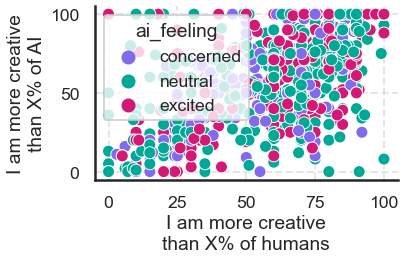

In [22]:
dfp['gap'] = dfp['creativity_ai'] - dfp['creativity_human']
sns.scatterplot(data=dfp, x="creativity_human", y="creativity_ai", hue='ai_feeling')
plt.xlabel("I am more creative\nthan X% of humans")
plt.ylabel("I am more creative\nthan X% of AI")

dfp.corr()

# Race conditions/trials

In [23]:
import pandas as pd
df = pd.read_csv("../../data/experiment_data/data_clean.csv")
counts = df.groupby(by=['response_chain', 'item', 'condition']).count().reset_index()[['response_chain', 'item', 'condition', 'response_id']]
counts = counts.rename(columns = {'response_id':'trials'})
counts.head()

,response_chain,item,condition,trials
0,0,bottle,f_l,19
1,0,bottle,f_u,19
2,0,bottle,h,19
3,0,bottle,m_l,19
4,0,bottle,m_u,19


In [24]:
desc = counts.describe()['trials']
print(desc)
print()
print(f"The average number of trials per response chain was {np.round(desc['mean'],2)} (SD = {np.round(desc['std'],2)}) and median number per chain was {int(desc['50%'])}. \
We concluded the experiment before the last round of response chains was completely finished for all condition X item\
 combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was {int(desc['min'])}. \
The maximum number of trials was {int(desc['max'])}" )

count    175.000000
mean      19.725714
std        1.451979
min       14.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       24.000000
Name: trials, dtype: float64

The average number of trials per response chain was 19.73 (SD = 1.45) and median number per chain was 20. We concluded the experiment before the last round of response chains was completely finished for all condition X item combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was 14. The maximum number of trials was 24


In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def handle_anova(dv):
    model_two_way = ols('trials ~ C(item) + C(condition) + C(item):C(condition)', data=counts).fit()
    anova_table_two_way = sm.stats.anova_lm(model_two_way, typ=3)
    print(anova_table_two_way)
    summ = anova_summary(anova_table_two_way, dv)

def anova_summary(anova_table, dv):
    summary = {}
    summary_str = f"{dv} was not related to "
    for index in anova_table.index:
        F = anova_table.loc[index, "F"]
        df = int(anova_table.loc[index, "df"])
        p_value = anova_table.loc[index, "PR(>F)"]
        summary[index] = f'F({df}) = {F:.2f}, p = {p_value:.2f}'
    for x in summary:
        x_clean = x.replace("C(", "").replace(")", "")
        if x_clean in ['item', 'condition', 'item:condition']:
            summary_str += f"{x_clean} $({summary[x]})$" + ","
    print(summary_str)
    return summary


handle_anova("trials")

                           sum_sq     df            F        PR(>F)
Intercept             2720.571429    1.0  1145.388933  4.133820e-72
C(item)                  3.600000    4.0     0.378909  8.234406e-01
C(condition)             0.114286    4.0     0.012029  9.997115e-01
C(item):C(condition)     0.480000   16.0     0.012630  1.000000e+00
Residual               356.285714  150.0          NaN           NaN
trials was not related to item $(F(4) = 0.38, p = 0.82)$,condition $(F(4) = 0.01, p = 1.00)$,item:condition $(F(16) = 0.01, p = 1.00)$,
